In [6]:
import cv2
import cv2.aruco
import numpy as np
from matplotlib import pyplot as plt

# from google.colab.patches import cv2_imshow
print(cv2.__version__)

4.7.0


# Tag-based Augmented Reality:

Index:
1. Introduction to ArUco markers
2. Drawing a Virtual Box

Today, we will explore a use case for tag-based AR, which superimposes the virtual cube on an tag in the photo. Specifically, we take a photo of an ArUco Tag, and we want to draw a 3D cube of the same size of the tag on the image, as if this virtual cube really is on top of the tag. Suppose we already have the camera intrinsic matrix K that is needed for computation. Here is the result we want to achieve:


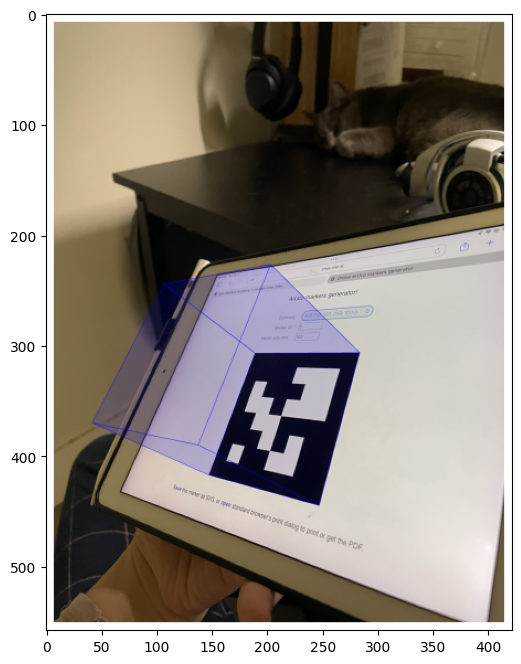

In [7]:
example = cv2.imread('example1.png')
example = cv2.cvtColor(example, cv2.COLOR_BGR2RGB)

fig=plt.figure(figsize=(20, 8))
plt.imshow(example)

ArUco is an open source library that can generate and process a special kind of fiducial tags called Aruco Tag. It's assumed that Ar stands for augmented reality and Uco is for University of Cordoba, Spain which developed this library.
Example of Aruco Tag looks like this:

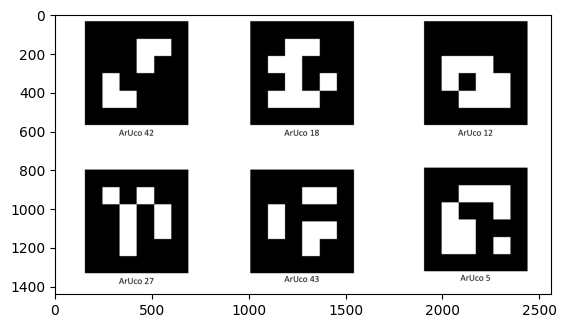

In [8]:
example = cv2.imread('example2.png')
example = cv2.cvtColor(example, cv2.COLOR_BGR2RGB)
plt.imshow(example)

ArUco tags are ubiquitous in robotics. They are good at providing a ground truth for detection and estimation. Below is a screenshot from Boston Dynamics' demo video from 2018

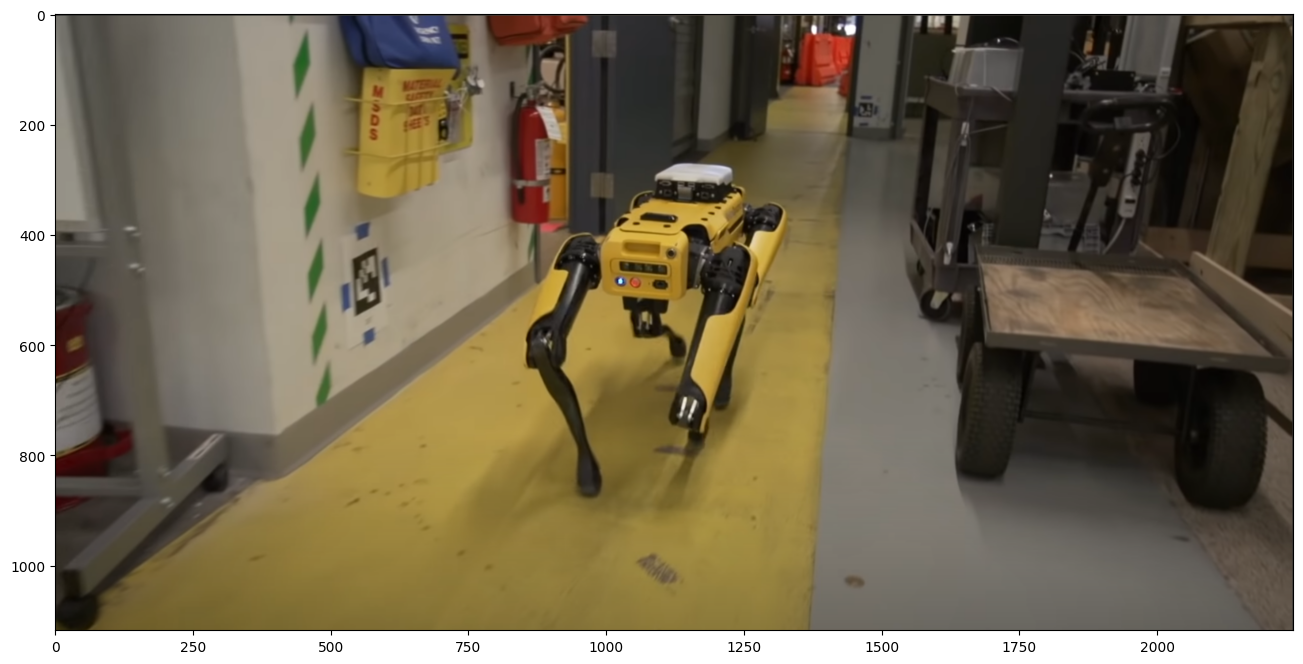

In [9]:
example = cv2.imread('example3.png')
example = cv2.cvtColor(example, cv2.COLOR_BGR2RGB)

fig=plt.figure(figsize=(20, 8))
plt.imshow(example)

Using [this website](https://chev.me/arucogen/), we can generate Aruco tags very easily.

You may notice that the website ask for a "dictionary". What does that mean? Usually, a Aruco dictionary would look like `DICT_4X4_50`, `DICT_6X6_100`. with an NxN followed by aother number M.

As it turns out, the NxN value is the 2D bit size of the ArUco marker. For example, for a 6×6 marker we have a total of 36 bits.

The integer M following the grid size specifies the total number of unique ArUco IDs that can be generated with that dictionary.

Usually, when we want to detect an AruCo tag, we will need to specify the dictionary of the target tag. This sounds like a bummer, but in real world application, the person who prints the tag will be the same person who do the detection, so it's not a huge issue. There are also way to automatically figure out the dictionary during the detection process. See [here for detecting Aruco tags in the wild](https://pyimagesearch.com/2020/12/21/detecting-aruco-markers-with-opencv-and-python/)

[This part is taken from [this online tutorial](https://pyimagesearch.com/2020/12/14/generating-aruco-markers-with-opencv-and-python/)]



Let's try to detect a tag

We define the Aruco dictionary we use, and the detector's parameters. We use the default parameters

In [5]:
aruco_dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_1000)
aruco_parameters = cv2.aruco.DetectorParameters()

4.7.0


`detectMarkers` detect the tags in a given image. It returns the 2D position of the corners in the image and its corresponding identifier.

In [10]:
source = cv2.imread('source.jpg')
source = cv2.cvtColor(source, cv2.COLOR_BGR2RGB) # This line is simply because I want to show the image using matplotlib, but OpenCV read image in BGR
res = cv2.aruco.detectMarkers(source, aruco_dictionary,
                parameters= aruco_parameters)

print(f'Corners: {res[0]}')
print(f'ID: {res[1]}')

Corners: (array([[[1351., 2223.],
        [2055., 2222.],
        [1780., 3247.],
        [1042., 3045.]]], dtype=float32),)
ID: [[0]]


`drawDetectedMarkers` returns an image with the tag drawn for you. (The green line is really thin for some reason)

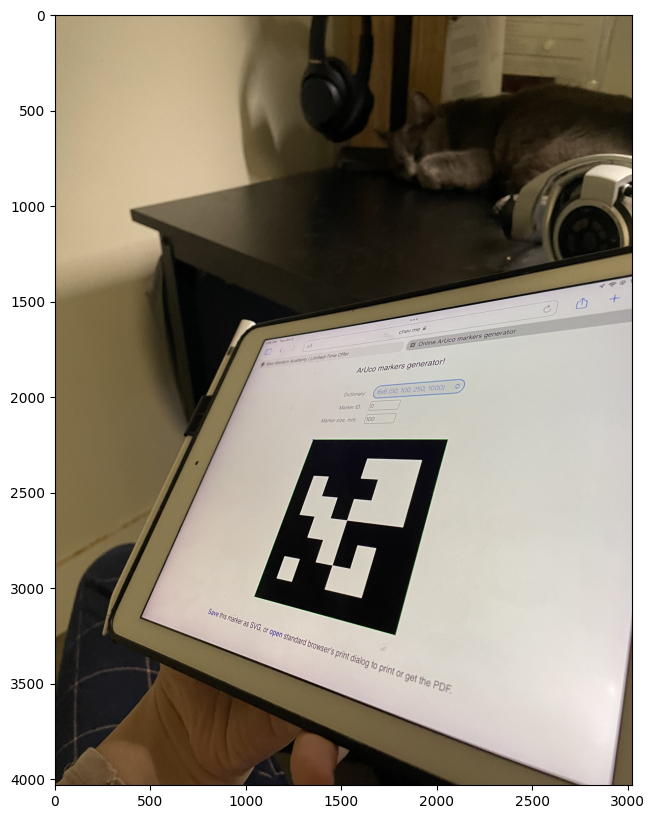

In [11]:
fig=plt.figure(figsize=(10, 10))
plt.imshow(cv2.aruco.drawDetectedMarkers(source, res[0]))

Then we try to draw the object frame coordinates based on the tag. Don't worry if you don't understand some of the things. We will walk through the details in the next section.

First we provide the camera calibration results

In [23]:
mtx = np.array([[3.00620270e+03, 0.00000000e+00, 1.50651456e+03],
       [0.00000000e+00, 3.01779164e+03, 1.98146724e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
dist = np.array([[ 1.06516093e-01, -3.07282376e-01, -3.85908161e-03,
        -1.60508446e-04,  3.23583309e-01]])

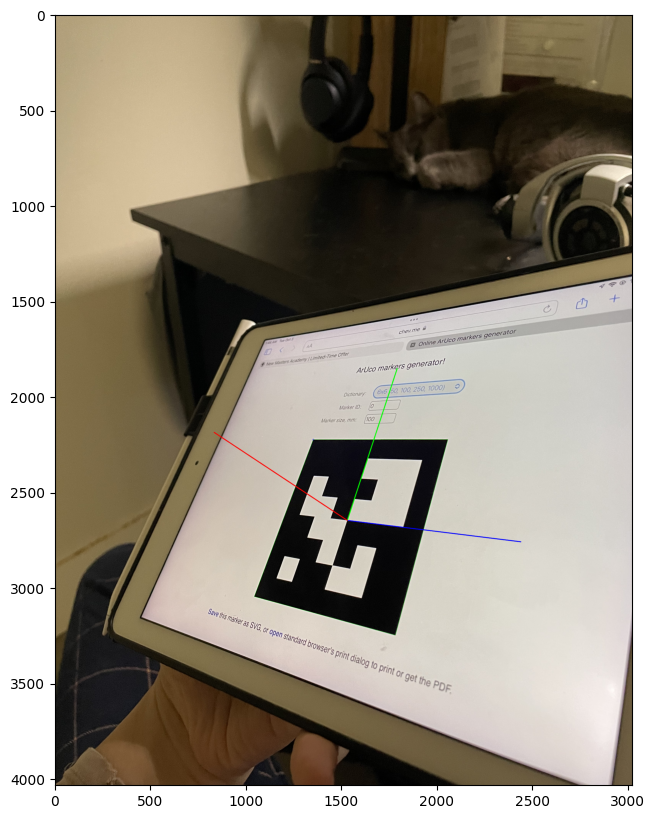

In [13]:
rvecs, tvecs, _ = cv2.aruco.estimatePoseSingleMarkers(res[0][0], 1, mtx, dist)
axis_drawn = cv2.drawFrameAxes(source, mtx, dist, rvecs, tvecs, 1)
fig=plt.figure(figsize=(15, 10))
plt.imshow(axis_drawn)

# 2. Drawing a Virtual Box

Again, we will need the camera calibration results, and the AruCo dictionary and parameters.

In [14]:
mtx = np.array([[3.00620270e+03, 0.00000000e+00, 1.50651456e+03],
       [0.00000000e+00, 3.01779164e+03, 1.98146724e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
dist = np.array([[ 1.06516093e-01, -3.07282376e-01, -3.85908161e-03,
        -1.60508446e-04,  3.23583309e-01]])

aruco_dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_1000)
aruco_parameters = cv2.aruco.DetectorParameters()

This helper function draw a box on top of a Aruco tag by:

1. Detect the Aruco tag, and acquire the 2D image plane coordinate of the tag corners
2. Estimate the pose (namely, the rotation and translation) that transforms a 3D point expressed in the object coordinate frame to the image plane coordinate frame. In this case the object coordinate frame is treating the center of the tag as the origin.
3. Draw a cube based on the 3D object coordinate frame
4. Project the 3D object coordinate to the 2D image plane coordinate
5. Finish drawing using OpenCV's utility functions

In [15]:
def draw_box(img_rgb):
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    res = cv2.aruco.detectMarkers(img_gray, aruco_dictionary,
                parameters = aruco_parameters)
    # Estimate pose of the tag
    rvecs, tvecs, _ = cv2.aruco.estimatePoseSingleMarkers(res[0][0], 1, mtx, dist) # here 1 means that we assume the length of the marker is 1
    # here the origin is at the center of the tag so we need some offset
    axis = np.float32([[-0.5, -0.5, 0], [-0.5, 0.5, 0], [0.5, 0.5, 0], [0.5, -0.5, 0],
                   [-0.5, -0.5, 1], [-0.5, 0.5, 1], [0.5, 0.5, 1],[0.5, -0.5, 1]]) # here we are drawing the 8 vertices of this cube. Remember that we assume the tag to be of length 1,
                   # and the origin is at the center of the cube, that's why we have a lot of 0.5 here

    # transform the cube to the marker position and do projection
    imgpts, jac = cv2.projectPoints(axis, np.float32(rvecs), np.float32(tvecs), mtx, dist)
    imgpts = np.int32(imgpts).reshape(-1, 2)

    # start drwaing
    side2 = img_rgb.copy()
    side3 = img_rgb.copy()
    side4 = img_rgb.copy()
    side5 = img_rgb.copy()
    side6 = img_rgb.copy()

    # top side
    side2 = cv2.drawContours(side2, [imgpts[4:]], -1, (255, 0, 0), -2)
    # right side vertical to the marker
    side3 = cv2.drawContours(side3, [np.array(
        [imgpts[0], imgpts[1], imgpts[5],
         imgpts[4]])], -1, (255, 0, 0), -2)
    # left side vertical to the marker
    side4 = cv2.drawContours(side4, [np.array(
        [imgpts[2], imgpts[3], imgpts[7],
         imgpts[6]])], -1, (255, 0, 0), -2)
    # front side vertical to the marker
    side5 = cv2.drawContours(side5, [np.array(
        [imgpts[1], imgpts[2], imgpts[6],
         imgpts[5]])], -1, (255, 0, 0), -2)
    # back side vertical to the marker
    side6 = cv2.drawContours(side6, [np.array(
        [imgpts[0], imgpts[3], imgpts[7],
         imgpts[4]])], -1, (255, 0, 0), -2)

    # now we put everything together.
    img_rgb = cv2.addWeighted(side2, 0.1, img_rgb, 0.9, 0)
    img_rgb = cv2.addWeighted(side3, 0.1, img_rgb, 0.9, 0)
    img_rgb = cv2.addWeighted(side4, 0.1, img_rgb, 0.9, 0)
    img_rgb = cv2.addWeighted(side5, 0.1, img_rgb, 0.9, 0)
    img_rgb = cv2.addWeighted(side6, 0.1, img_rgb, 0.9, 0)

    img_rgb = cv2.drawContours(img_rgb, [imgpts[:4]], -1, (255, 0, 0), 2)
    for i, j in zip(range(4), range(4, 8)): # this is basically putting the five side of this cube together
        img_rgb = cv2.line(img_rgb, tuple(imgpts[i]), tuple(imgpts[j]), (255, 0, 0), 2)
    img_rgb = cv2.drawContours(img_rgb, [imgpts[4:]], -1, (255, 0, 0), 2)

    fig = plt.figure(figsize=(20, 10))
    plt.imshow(cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
    plt.axis('off');

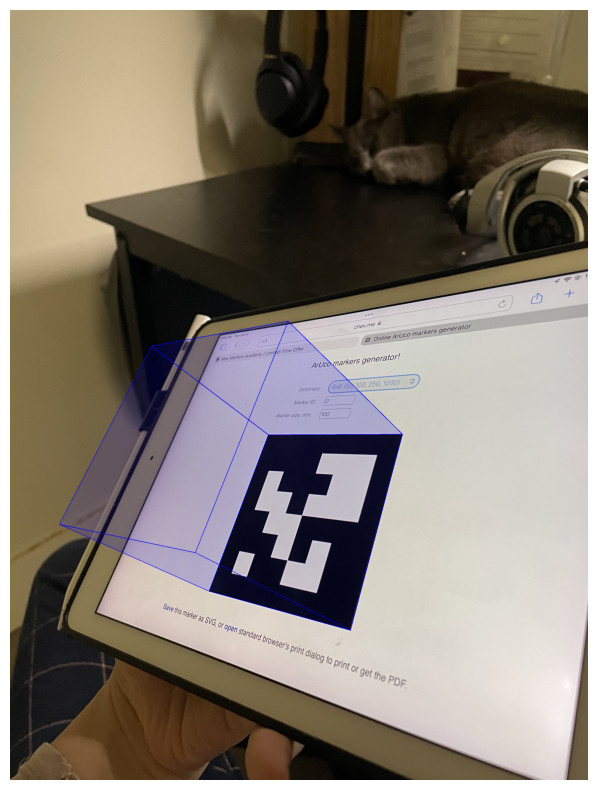

In [16]:
source = cv2.imread('./source.jpg')
draw_box(source)

# Homework

For this week's homework, you will draw an Augmented Reality object (could be a cube or a cuboid or a pyramid) of your choice on an ArUco tag video taken from your own calibrated camera.


Please complete the following tasks and upload the required material to the [HW3 Google Form](https://forms.gle/HVuVponMZM6q4haw6).


Tasks:-

1. Capture a 5 second video of an ArUco tag from your own calibrated camera. Do not keep the tag in one place itself, it should be displaced and rotated making sure that the tag is visible in all frames of the video. [Link to example video](https://drive.google.com/file/d/1PsmyGPeQXl9aY9Hb3X1C_w3pgLfRc_Yn/view?usp=sharing).
2. Process each frame of the video, draw an Augmented Reality object on the ArUco tag and save it as a video. Upload the final video with the AR object drawn on all frames of the recorded video. [Link to example output video](https://drive.google.com/file/d/14B6jQzgFBjczgMOeVkLB1lOWxjZ_vg-c/view?usp=drive_link).
